In [1]:
import lmfit as lm
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
from edo_model_yang import C0, A0, R_m
from lmfit import Parameters, Minimizer
from edo_model_yang import system_odes, solve_model, solve_fit, plot_fit
from get_data import get_weather_data, get_dengue_data, plot_data, get_temp
from parameters import d, theta_m, mu_a, mu_m, gamma_m, C_yang, sup_cap_sin, sup_cap_yang

In [2]:
# parâmetros que serão fixados: 
# parâmetros fixos 
MU_H = 1/(365*67)    #human mortality rate - day^-1
ALPHA_H = 0.1 #recovering rate - day^-1
THETA_H = 0.027   #intrinsic incubation rate - day^-1
K = 0.5          #fraction of female mosquitoes hatched from all egs
C_A = 0.0      #control effort rate on aquatic phase
C_M = 0.0    #control effort rate on terretrial phase

# população de Foz (censo 2010)
N = 256088

par_fixed = MU_H, THETA_H, ALPHA_H, K, C_A, C_M

In [3]:
df = get_dengue_data()
df.head()

,notified,probable,lab_confirmed,acum_notified
date,,,,
2010-01-07,1.571429,0.857143,0.285714,1.571429
2010-01-08,1.857143,1.000000,0.142857,3.428571
2010-01-09,1.857143,1.000000,0.142857,5.285714
2010-01-10,2.000000,1.142857,0.142857,7.285714
2010-01-11,1.714286,0.857143,0.142857,9.000000


Definindo as condições iniciais

In [4]:
Ms_0 = N

# para T = 28
k = 0.5
delta__ = 8.39
gamma_m__ = 0.12
mu_a__ = 0.06848
mu_m__ = 0.03039
c_m__ = 0.0

A_0 = A0(Ms_0, gamma_m__, mu_m__, c_m__)

C_0 = C0(Ms_0,k,delta__,gamma_m__, mu_m__,mu_a__, c_m = 0, c_a = 0)

Hi0 = 15
Mi0 = 0

print("A0:", A_0)
print("C0:", C_0)

A0: 64854.28600000001
C0: 65600.71992125978


In [5]:
df_2010 = df.loc[(df.index >= '2010-01-08')  &  (df.index <= '2011-12-31')]

data = df_2010.acum_notified

T = np.round_(get_temp(start_date = '2010-01-08', end_date = '2011-12-31'), decimals = 1)

df_we = get_weather_data()

df_we = df_we.loc[(df_we.index >= '2010-01-01') & (df_we.index <= '2011-12-31')]

dias = np.arange(0, len(data), 1)

In [6]:
def briere(T, a, b, c):
    
    return a*T*(T-b)*((c-T)**(1/2))

def b(a, T):
    
    values = []
    for temp in T:
        if (temp > 34) | (temp < 18):
            v = 0
        else: 
            v = briere(temp, a = a, b=18, c = 34)
            
        values.append(v)
    
    return values


def b_(a, T):
    
    dias = np.arange(0, len(T))
  
    f = interpolate.interp1d(dias, b(a, T))
    
    return f 


def beta(a, T):
    
    values = []
    for temp in T:
        if (temp > 34) | (temp < 18):
            v = 0
        else: 
            v = briere(temp, a = a, b=18, c = 34)
            
        values.append(v)
    
    return values

def beta_(a, T):
    
    dias = np.arange(0, len(T))
  
    f = interpolate.interp1d(dias, beta(a, T))
    
    return f 

In [7]:
def fun_obj_var(params, t, data, par_fixed, T, df_we, A0, Mi0, Hi0, N = 256088): 

    """
    Função objetivo utilizada para o fitting

    ----------
    params : Parametros definidos de acordo com o lmfit 
        Os parâmetros que serão fitados 
    t : list, np.array
        lista com os valores temporais, [0, 1, 2, 3, 4, ..., n] 
    data : np.array
        Array com os dados
    r0: list
      Lista com as condições iniciais para analisar o modelo 
    Returns
    -------
    pd.DataFrame
        Dataframe with the lagged values computed.
    """

    # Aqui serão definidos os parâmetros que serão fitados 
    pars = params.valuesdict()
    
    b = b_(pars['a_b'], T)
    
    beta = beta_(pars['a_beta'], T)
  
    parametros = b, beta
    
    d_ = d(T)
    
    gamma_m_ = gamma_m(T)
    
    mu_a_ = mu_a(T)

    mu_m_ = mu_m(T)
    
    theta_m_ = theta_m(T)
    
    C_ = C_yang(df_we, k=7,w1=0.5, C0 = pars['C0'] , C1=30,C2 = pars['C2'])
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    phi = 1
    
    # definição das condições iniciais
    Ms0 = N
    
    Me0 = 0
    
    Hs0 = phi*N
    
    He0 = 0
    
    Hr0 = (1-phi)*N
    
    y0 = [A0, Ms0, Me0, Mi0, Hs0, He0, Hi0, Hr0]

    # Aqui é solucionado o sistema 
    
    try:
        r = solve_model(t, y0, parametros, param_ento, par_fixed)

        Hi = r.y[6]
        Hr = r.y[7] - Hr0

        model = Hi + Hr 

        res = (model) - data
    
    except:
        
        print('Deu merda')
        print(pars)
        
        
        res = data

    return res  

def solve_fit(out, t, par_fixed, T, df_we, A0, Mi0, Hi0, N = 256088): 
    '''
    Retorna a saída do modelo com os parâmetros fitados. 

    :params out: saída do lmfit. 
    :params t: array. Intervalo de tempo que deverá ser computado. 
    :params y0: list or array. Deve conter os valores das condições iniciais do modelo. 
    :params temp: array. Array com os valores de temperatura. O tamanho desse array deve ser 
                        condizente com o intervalo de tempo que o modelo será integrado. 
    :params df_we: pd.Dataframe or None. No caso de um dataframe será computado as capacidade
                    suporte usando a fórmula do Yang. 
    :params fixed: boolean. Se True serão usados os parâmetros ontomológicos fixos. 
    '''
    pars = out.params
    pars = pars.valuesdict()
    
    phi = 1
  
    b = b_(pars['a_b'], T)
    
    beta = beta_(pars['a_beta'], T)
  
    par_fit = b, beta
    
    d_ = d(T)
    
    gamma_m_ = gamma_m(T)
    
    mu_a_ = mu_a(T)
    
    mu_m_ = mu_m(T)
    
    theta_m_ = theta_m(T)
    
    C_ = C_yang(df_we, k=7,w1=0.5, C0 = pars['C0'], C1 = 30, C2 = pars['C2'])
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    # definição das condições iniciais
    Ms0 = N
    
    Me0 = 0
    
    Hs0 = phi*N
    
    He0 = 0
    
    Hr0 = (1-phi)*N
    
    y0 = [A0, Ms0, Me0, Mi0, Hs0, He0, Hi0, Hr0]
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    r_fit = solve_model(t, y0, par_fit, param_ento, par_fixed)

    return r_fit.y[6] + (r_fit.y[7] - Hr0)

In [8]:
%%time
# definição dos parâmetros que serão fitados e os seus intervalos 
params = Parameters()


params.add('a_b', value = 0.0010, min = 0.0001, max = 0.00138, vary = True)
params.add('a_beta',value = 0.0011, min = 0.0001, max = 0.00138, vary = True)
params.add('C0', value = 5, min = 4, max = 8, vary = True)
params.add('C2', value = 0.1, min = 0.09, max = 0.5, vary = True)

out = lm.minimize(fun_obj_var, params, args = (dias, data, par_fixed, T, df_we, A_0, Mi0, Hi0), method = 'leastq')

lm.report_fit(out)

Deu merda
{'a_b': 0.0011560045793117912, 'a_beta': 0.0012912615698039704, 'C0': 5.402580662315286, 'C2': 0.24453455447451009}
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 560
    # data points      = 723
    # variables        = 4
    chi-square         = 1.5473e+09
    reduced chi-square = 2152053.27
    Akaike info crit   = 10546.7264
    Bayesian info crit = 10565.0601
[[Variables]]
    a_b:     0.00134155 +/- 2.9014e-08 (0.00%) (init = 0.001)
    a_beta:  0.00110564 +/- 7.4107e-08 (0.01%) (init = 0.0011)
    C0:      4.85335321 +/- 2.6887e-04 (0.01%) (init = 5)
    C2:      0.49919184 +/- 2.5119e-06 (0.00%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a_beta, C2) = 0.423
    C(a_b, C0)    = -0.385
    C(a_beta, C0) = 0.136
CPU times: user 35min 42s, sys: 6.26 s, total: 35min 49s
Wall time: 35min 49s


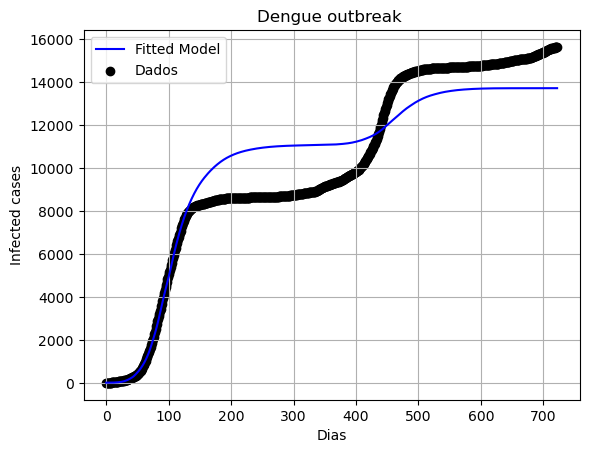

In [9]:
H_fit = solve_fit(out, dias, par_fixed, T, df_we, A_0, Mi0, Hi0, N = 256088)

plot_fit(dias, data, H_fit)

Plotando a curva dos parâmetros fitados:

In [10]:
df_we

,daily_precipitation-mm,temp_max-celsius,temp_min-celsius,temp_mean-celsius,mean_relative_humidity-%,mean_wind_speed-m_per_s
date,,,,,,
2010-01-01,0.0,31.1,23.9,26.7,72.1,1.7
2010-01-02,2.2,32.9,23.8,27.2,75.3,1.3
2010-01-03,0.0,32.3,25.6,28.4,73.2,1.7
2010-01-04,1.6,33.9,24.6,28.5,75.5,2.5
2010-01-05,0.2,35.2,25.5,29.5,69.1,2.6
...,...,...,...,...,...,...
2011-12-27,0.0,31.6,22.6,26.5,76.2,1.8
2011-12-28,0.0,36.3,22.5,28.5,66.3,1.3
2011-12-29,0.0,33.2,22.6,26.9,70.2,2.0


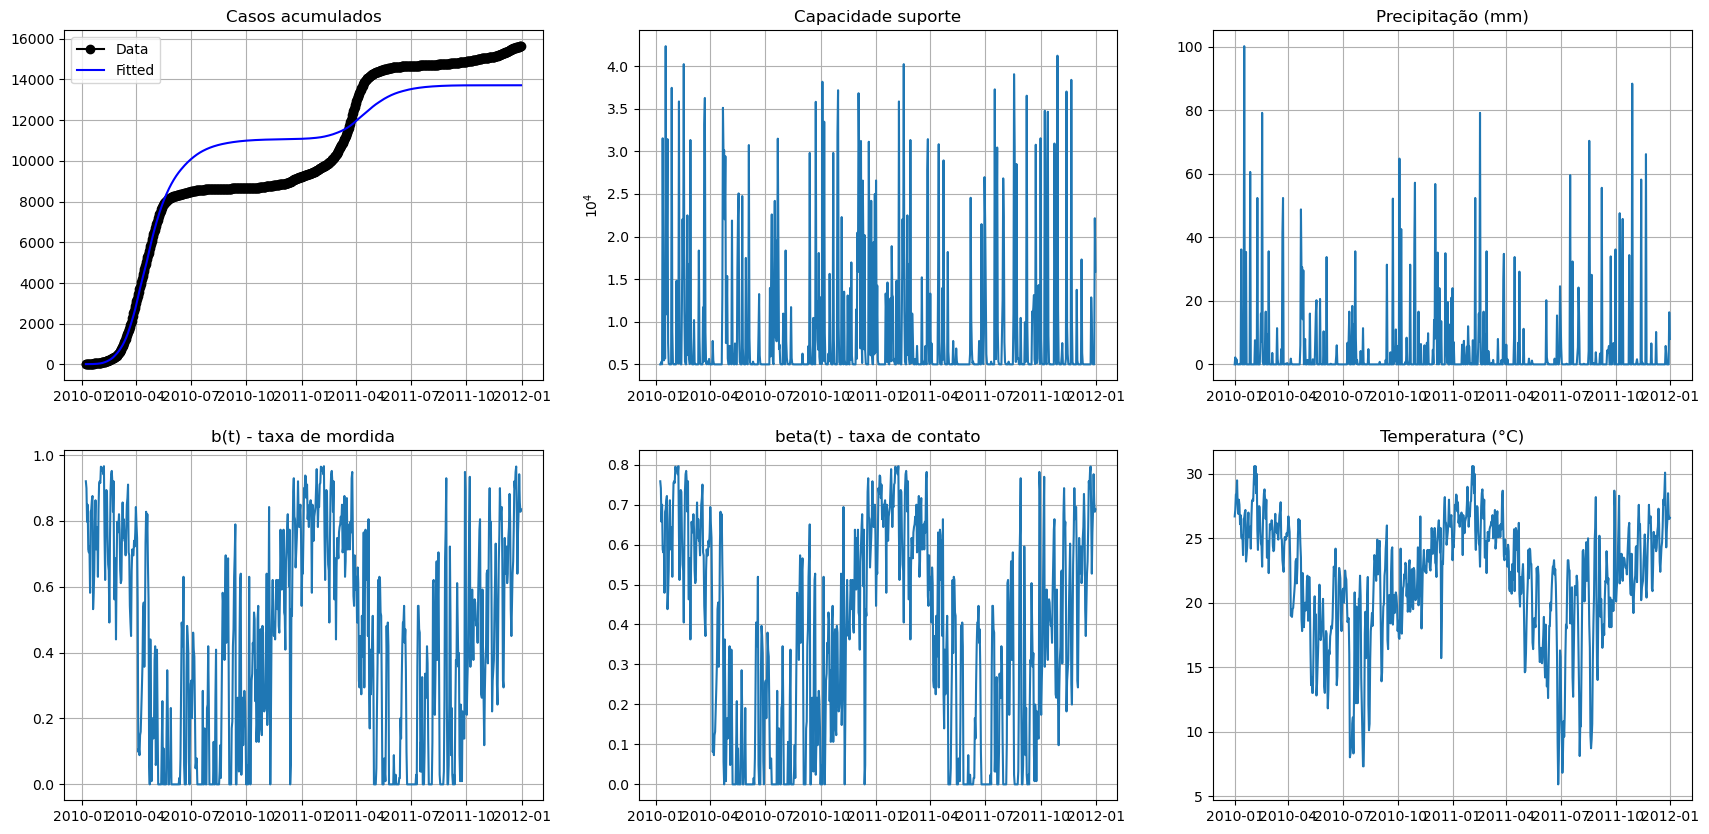

In [11]:
pars = out.params.valuesdict()

fig, ax = plt.subplots(2,3, figsize = (21,10))

ax[0,0].plot(data, label = 'Data', color = 'black', marker = 'o')

ax[0,0].plot(data.index, H_fit, label = 'Fitted', color = 'blue')

ax[0,0].set_title('Casos acumulados')

ax[0,0].legend()

ax[0,0].grid()

ax[0,1].plot(data.index, sup_cap_yang(df_we, k=7,w1=0.5, C0 = pars['C0'], C1 = 30, C2 = pars['C2']))

ax[0,1].set_title('Capacidade suporte')

ax[0,1].set_ylabel('$10^4$')

ax[0,1].grid()

ax[1,0].plot(data.index, b(pars['a_b'], T))

ax[1,0].set_title('b(t) - taxa de mordida')

ax[1,0].grid()

ax[1,1].plot(data.index,  beta(pars['a_beta'], T))

ax[1,1].set_title('beta(t) - taxa de contato')

ax[1,1].grid()


ax[0,2].plot(df_we['daily_precipitation-mm'])

ax[0,2].set_title('Precipitação (mm)')

ax[0,2].grid()

ax[1,2].plot(df_we['temp_mean-celsius'])

ax[1,2].set_title('Temperatura (°C)')

ax[1,2].grid()

Como o b(t) e o beta(t) variam em relação a temperatura:

In [12]:
T.min()

5.9

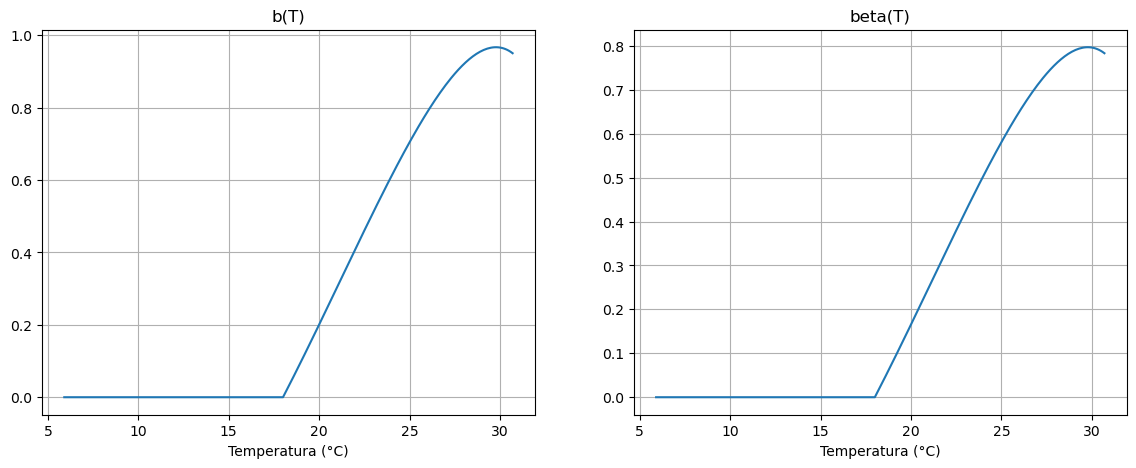

In [13]:
fig, ax = plt.subplots(1,2, figsize = (14,5))

temp = np.arange(T.min(), T.max() + 0.1, 0.1 )

ax[0].plot(temp, b(pars['a_b'], temp))

ax[0].set_title('b(T)')

ax[0].set_xlabel('Temperatura (°C)')

ax[0].grid()

ax[1].plot(temp, beta(pars['a_beta'], temp))

ax[1].set_title('beta(T)')

ax[1].set_xlabel('Temperatura (°C)')

ax[1].grid()


Comparando com os outros fittings: 

In [14]:
df = pd.read_csv('testing_fit.csv')
df.set_index('date', inplace = True)

df.index = pd.to_datetime(df.index)

df

,target,pred_fix,pred_onto,pred_cap
date,,,,
2010-01-08,3.428571,15.000000,15.000000,15.000000
2010-01-09,5.285714,14.999561,13.080030,14.991113
2010-01-10,7.285714,15.001360,11.161720,14.986625
2010-01-11,9.000000,15.010321,9.248445,14.995815
2010-01-12,11.428571,15.033266,7.344961,15.031578
...,...,...,...,...
2010-07-26,8598.857143,12107.927730,12882.612520,11363.029850
2010-07-27,8601.285714,12463.824891,13095.652417,11438.137587
2010-07-28,8603.714286,12829.419585,13308.012322,11512.122056


ValueError: x and y must have same first dimension, but have shapes (204,) and (723,)

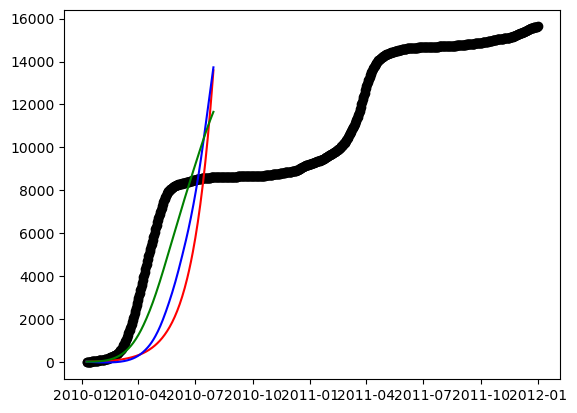

In [15]:
fig, ax = plt.subplots()
 
ax.scatter(data.index, data.values,color='black',label='Dados')

ax.plot(df.index, df.pred_fix, color='red',label='parametros onto fixos')

ax.plot(df.index, df.pred_onto, color='blue',label='Variando de onto parametros')

ax.plot(df.index, df.pred_cap, color='green',label='cap suporte variável')

ax.plot(df.index, H_fit, color='tab:orange',label='b e beta dep do tempo')
    
#Set the labels
ax.set_ylabel('Casos notificados acumulados')
ax.set_xlabel('Data')

#Create a grid for visualization
ax.grid()

#Set the title
ax.set_title('Comparativo do fitting')
#The size of the numbers on the axixis

plt.legend()
plt.show()